# Reto: Precio por m2


# Primera parte: 

- La base inicial se transformó utiluzando PowerQuery en Excel.
- Se dividió columnas de locación para obtener tres columnas: calle, colonia y estado.
- Se eliminaron 16 columnas que repetían información para quedar con 18 columnas.
- La columna "disposition" contaba únicamente con 20 observaciones, por lo que se eliminó.
- Aun se presenta errores en las columnas de texto, caracteres especiales en nombres.


In [1]:
#Dependencias
import csv
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

In [2]:
# Dependencias para modelo de regresión lineal
import sklearn as skl
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score
import statsmodels.api as sm

In [3]:
# Dependencias para modelo de random forest
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

C:\Users\alelo\anaconda3\lib\site-packages\sklearn\experimental\enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


# Cargando la base

In [5]:
reto_precios_to_load= 'C:/Users/alelo/Documents/DD360/Precios_por_m2/reto_precios_v1.csv'


# Análisis Exploratorio

In [6]:
#Convirtiendo la base en Dataframe
precios_df= pd.read_csv(reto_precios_to_load)

#Primeras filas del dataframe
precios_df.head()

,street,suburb,state,vendor,lat,lon,days_on_site,amenities,bathrooms,cellars,num_floors,monthly_fee_mxn,parking_lots,beds,department_type,m2,final_price,price_square_meter
0,Sinaloa 20,"Roma Sur, Roma Sur, Cuauhtémoc",Distrito Federal,Investemx,19.421317,-99.164182,5,3,2,0,1,0.0,2,2,apt,127.0,9000000.0,70866.14
1,Tonala,"Roma Norte, Cuauhtémoc",Distrito Federal,Avitana,19.421029,-99.163541,7,2,1,0,0,0.0,1,1,apt,54.0,4264000.0,78962.96
2,Tepeji 43,"Roma Sur, Ciudad De México, Cdmx, México, Rom...",Distrito Federal,Ebranuncios,19.407814,-99.161872,4,0,3,2,3,0.0,2,3,apt,163.0,8093500.0,49653.37
3,Linares,"Roma Sur, Cuauhtémoc",Distrito Federal,Houm,19.404992,-99.160243,150,2,2,0,0,853.0,1,2,Loft,93.0,4000000.0,43010.75
4,Frontera,"Roma Norte, Cuauhtémoc",Distrito Federal,Contactobienesraicesgold,19.419693,-99.156036,52,4,2,0,0,0.0,1,2,apt,103.0,6732700.0,65366.02


In [7]:
# Información sobre las columnas y observaciones
precios_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 981 entries, 0 to 980
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   street              981 non-null    object 
 1   suburb              981 non-null    object 
 2   state               981 non-null    object 
 3   vendor              981 non-null    object 
 4   lat                 981 non-null    float64
 5   lon                 981 non-null    float64
 6   days_on_site        981 non-null    int64  
 7   amenities           981 non-null    int64  
 8   bathrooms           981 non-null    int64  
 9   cellars             981 non-null    int64  
 10  num_floors          981 non-null    int64  
 11  monthly_fee_mxn     981 non-null    float64
 12  parking_lots        981 non-null    int64  
 13  beds                981 non-null    int64  
 14  department_type     981 non-null    object 
 15  m2                  981 non-null    float64
 16  final_pr

In [8]:
precios_df.isnull().sum()

street                0
suburb                0
state                 0
vendor                0
lat                   0
lon                   0
days_on_site          0
amenities             0
bathrooms             0
cellars               0
num_floors            0
monthly_fee_mxn       0
parking_lots          0
beds                  0
department_type       0
m2                    0
final_price           0
price_square_meter    0
dtype: int64

In [9]:
# Información sobre estadísticas descriptivas
precios_df[['days_on_site', 'amenities', 'bathrooms', 'cellars', 'num_floors', 'monthly_fee_mxn', 'parking_lots', 'beds', 'm2', 'final_price', 'price_square_meter']].describe().round(2)

,days_on_site,amenities,bathrooms,cellars,num_floors,monthly_fee_mxn,parking_lots,beds,m2,final_price,price_square_meter
count,981.00,981.00,981.00,981.00,981.00,981.00,981.00,981.00,981.00,981.00,981.00
mean,103.48,2.10,1.97,0.05,0.31,28.92,1.33,2.10,111.82,6144619.88,61049.00
std,116.79,2.23,0.89,0.23,1.30,287.13,0.48,0.63,231.60,2907088.80,19327.44
min,1.00,0.00,1.00,0.00,0.00,0.00,1.00,1.00,31.00,634217.00,582.25
25%,31.00,0.00,2.00,0.00,0.00,0.00,1.00,2.00,75.00,4330000.00,52294.12
50%,59.00,2.00,2.00,0.00,0.00,0.00,1.00,2.00,93.00,5511689.00,61271.47
75%,120.00,4.00,2.00,0.00,0.00,0.00,2.00,2.00,129.00,7700000.00,70175.44
max,730.00,8.00,23.00,2.00,12.00,4000.00,3.00,4.00,7210.00,22330000.00,150514.82


 ## Existen tres variables que muestran comportamiento extraño, es decir mínimos y máximos muy extremos, por loque se analizarpan con mayor profundidad.
 

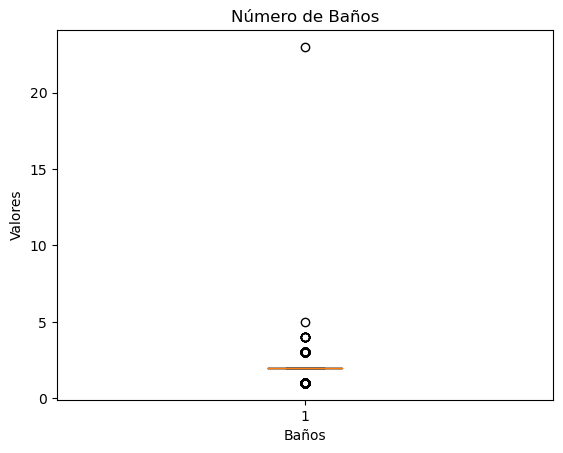

In [10]:
# box plot para número de baños, ya que el máximo es 23 y es un número ilógico para un departamento
plt.boxplot(precios_df['bathrooms'])

# Etiquetas de los ejes y título
plt.xlabel('Baños')
plt.ylabel('Valores')
plt.title('Número de Baños')

# Mostrar el box plot
plt.show()

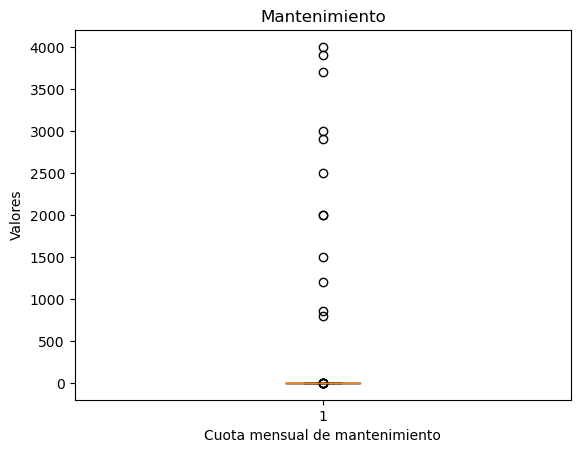

In [11]:
# Box plot para cuota mensual de mantenimiento para revisar si son outliers
plt.boxplot(precios_df['monthly_fee_mxn'])

# Etiquetas de los ejes y título
plt.xlabel('Cuota mensual de mantenimiento')
plt.ylabel('Valores')
plt.title('Mantenimiento')

# Mostrar el box plot
plt.show()

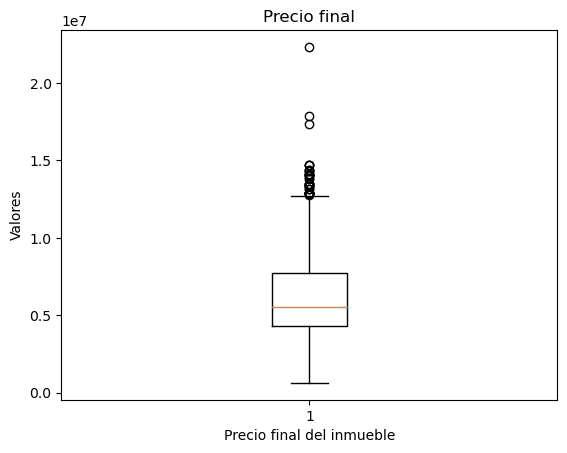

In [12]:
# Box plot para precio final
plt.boxplot(precios_df['final_price'])

# Etiquetas de los ejes y título
plt.xlabel('Precio final del inmueble')
plt.ylabel('Valores')
plt.title('Precio final')

# Mostrar el box plot
plt.show()

## Se confirma outliers y se revisa la desviación estándar de cada una de las tres variables

In [13]:
# Número de baños- outliers
# Calcular la media y la desviación estándar para Número de baños, su máximo es de 23 y mínimo 0.
# Valores más altos de desviación estándar indican una mayor variabilidad en la cantidad de baños.
# Se redondeo el número de baños porque en la practica así debe de ser.
mean = np.mean(precios_df['bathrooms'])
std = np.std(precios_df['bathrooms'])

# Definir el umbral (por ejemplo, 3 veces la desviación estándar)
threshold = 3 * std

print("Promedio de baños es de aprox: {:.0f}".format(mean))
print(f"La dispersión de los valores con respecto a la media es de: {std:.2f}")
print("El límite a partir del cual se consideran los valores como atípicos: {:.0f}".format(threshold))


Promedio de baños es de aprox: 2
La dispersión de los valores con respecto a la media es de: 0.89
El límite a partir del cual se consideran los valores como atípicos: 3


In [14]:
# Cuota de mantenimiento- outliers
# Calcular la media y la desviación estándar para Cuota de mantenimiento, máximo 4 mil, mínimo 0.
# Valores más altos de desviación estándar indican una mayor variabilidad en la cuota de mantenimiento.

mean = np.mean(precios_df['monthly_fee_mxn'])
std = np.std(precios_df['monthly_fee_mxn'])

# Definir el umbral (por ejemplo, 3 veces la desviación estándar)
threshold = 3 * std

print("Promedio de cuota de manteniemto es de aprox: {:.2f}".format(mean))
print(f"La dispersión de los valores con respecto a la media es de: {std:.2f}")
print("El límite a partir del cual se consideran los valores como atípicos: {:.2f}".format(threshold))

Promedio de cuota de manteniemto es de aprox: 28.92
La dispersión de los valores con respecto a la media es de: 286.99
El límite a partir del cual se consideran los valores como atípicos: 860.97


In [15]:
# Cuota de precio final- outliers
# Calcular la media y la desviación estándar para Precio final.
# Valores más altos de desviación estándar indican una mayor variabilidad en el precio final.

mean = np.mean(precios_df['final_price'])
std = np.std(precios_df['final_price'])

# Definir el umbral (por ejemplo, 3 veces la desviación estándar)
threshold = 3 * std

print("Promedio de precio final es de aprox: {:,.2f}".format(mean))
print(f"La dispersión de los vlores con respecto a la media es de: {std:,.2f}")
print("El límite a partir del cual se consideran los valores como atípicos: {:,.2f}".format(threshold))

Promedio de precio final es de aprox: 6,144,619.88
La dispersión de los vlores con respecto a la media es de: 2,905,606.73
El límite a partir del cual se consideran los valores como atípicos: 8,716,820.19


In [16]:
# DataFrame con las variables relevantes
variables = ['days_on_site', 'amenities', 'bathrooms', 'cellars', 'num_floors', 'monthly_fee_mxn', 'parking_lots', 'beds', 'm2', 'final_price', 'price_square_meter']
precios_df2 = precios_df[variables]

# Eliminar NaN si existen
precios_df2.dropna(inplace=True)

# Separar variables de entrada y variable objetivo
X = precios_df2.drop('price_square_meter', axis=1)
y = precios_df2['price_square_meter']

# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear el modelo HistGradientBoostingRegressor
model = HistGradientBoostingRegressor(max_iter=100)

# Ajustar el modelo con los datos de entrenamiento
model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

# Calcular las métricas de evaluación
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Imprimir las métricas de evaluación
print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R^2 Score:", r2)

C:\Users\alelo\AppData\Local\Temp\ipykernel_11488\86698273.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  precios_df2.dropna(inplace=True)


Mean Absolute Error: 1916.5354076049741
Mean Squared Error: 22009591.838069756
Root Mean Squared Error: 4691.438141771642
R^2 Score: 0.9449029467194568


# Evaluación del modelo

Las mpetricas de MAPE(Mean Absolute Percentage Error) se utiliza para evaluar el rendimiento de modelos de predicción cuando los valores son porcentajes; en este caso, los valores son absolutos por lo que utilizaré las métricas siguientes para evaluar el rendimiento del modelo de regresión:

1. MAE (Mean Absolute Error)
2. MSE (Mean Squared Error)
3. RMSE (Root Mean Squared Error) 
4. R2 (Coefficient of Determination) 

## Implementación

In [20]:
# Dependencia para implementación de MLOps
import joblib
import logging
import mlflow
import mlflow.sklearn


In [21]:
# Configuración de registro
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')


In [22]:
# Cargar datos
reto_precios_to_load = 'C:/Users/alelo/Documents/DD360/Precios_por_m2/reto_precios_v1.csv'
precios_df = pd.read_csv(reto_precios_to_load)


In [23]:
# DataFrame con las variables relevantes
variables = ['days_on_site', 'amenities', 'bathrooms', 'cellars', 'num_floors', 'monthly_fee_mxn',
             'parking_lots', 'beds', 'm2', 'final_price', 'price_square_meter']
precios_df2 = precios_df[variables]

In [24]:
# Eliminar NaN si existen
precios_df2.dropna(inplace=True)

C:\Users\alelo\AppData\Local\Temp\ipykernel_11488\650052981.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  precios_df2.dropna(inplace=True)


In [25]:
# Separar variables de entrada y variable objetivo
X = precios_df2.drop('price_square_meter', axis=1)
y = precios_df2['price_square_meter']

In [26]:
# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [27]:
# Crear el modelo HistGradientBoostingRegressor
model = HistGradientBoostingRegressor(max_iter=100)

In [28]:
# Ajustar el modelo con los datos de entrenamiento
model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

In [29]:
# Calcular las métricas de evaluación
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

In [30]:
# Imprimir las métricas de evaluación
print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R^2 Score:", r2)

Mean Absolute Error: 1916.5354076049741
Mean Squared Error: 22009591.838069756
Root Mean Squared Error: 4691.438141771642
R^2 Score: 0.9449029467194568


In [31]:
# Guardar el modelo entrenado
logging.info("Guardando el modelo...")
joblib.dump(model, 'modelo.pkl')


2023-05-26 16:47:52,225 - INFO - Guardando el modelo...


['modelo.pkl']

In [32]:
# Implementación de MLOps utilizando MLflow
logging.info("Implementando MLOps...")


2023-05-26 16:47:57,460 - INFO - Implementando MLOps...


In [33]:
# Iniciar la ejecución de MLflow
mlflow.start_run()

<ActiveRun: >

In [34]:
# Registrar los parámetros del modelo
mlflow.log_params(model.get_params())

In [35]:
# Registrar las métricas de evaluación
mlflow.log_metric("mae", mae)
mlflow.log_metric("mse", mse)
mlflow.log_metric("rmse", rmse)
mlflow.log_metric("r2", r2)

In [36]:
# Guardar el modelo en MLflow
mlflow.sklearn.log_model(model, "model")


C:\Users\alelo\anaconda3\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [37]:
# Finalizar la ejecución de MLflow
mlflow.end_run()